# House Sales in King County, USA
### Predict house price using regression

# Załącznik

In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE 
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('kc_house_data.csv')
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Dataframe zawiera dane typu :
 - 

Dane zawierają takie dane jak:
- id - unikalny id domu
- date - data sprzedaży domu
- price - cena sprzedanego domu


- bedrooms
- bathrooms - liczba łazienek, gdzie 0.5 znaczy łazienka bez prysznica
- sqft_living - powierzchnia mieszkalna
- sqft_lot - powierzchnia ogródka
- sqft_above - powierzchnia domu nad powierzchnią ziemi 
- sqft_basement
- yr_built
- yr_renovated
- floors - liczba pięter


- waterfront - Zmienna określająca czy mieszkanie wychodziło na nabrzeże
- view - ocena widoku [0, 4]
- condition - stan mieszkania [1, 5]
- grade - ocena zgodności budynku z projektem i jakości wykonania [1, 13]


- zipcode
- lat - Szerokość geograficzna
- long - Długość geograficzna
- sqft_living15 - powierzchnia mieszkań najbliższych 15 sąsiadów
- sqft_lot15 - powierzchnia ziemi najbliższych sąsiadów

Możemy wyszczególnić w tych danych 4 kategorie:
 - dane ogólne
 - specyfikacja domu
 - dane które są wyznaczane przez ludzi
 - dane o okolicy domu

Wynika stąd, że dane typu "id" powinny zostać usunięte z tego względu, że mogą powodować szum, z drugiej strony w id może być ukryta jakaś informacja, z której model mógłby wywnioskować cenę. Aby przygotować dane należy też udostępnić datę sprzedaży w bardziej przystępnym formacie.

In [3]:
df[['year', 'month', 'day']] = pd.DataFrame([ [int(x[0:4]), int(x[4:6]), int(x[6:8])] for x in df['date'].tolist() ])
df = df.drop(['date', 'id'], axis=1)
Y = df['price']
X = df.drop(['price'], axis=1)

In [4]:
df.groupby(['condition']).count()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
condition,,,,,,,,,,,,,,,,,,,,,
1,30,30,30,30,30,30,30,30,30,30,...,30,30,30,30,30,30,30,30,30,30
2,172,172,172,172,172,172,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
3,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031,...,14031,14031,14031,14031,14031,14031,14031,14031,14031,14031
4,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679,...,5679,5679,5679,5679,5679,5679,5679,5679,5679,5679
5,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701,...,1701,1701,1701,1701,1701,1701,1701,1701,1701,1701


In [5]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y,  
                      test_size = 0.3, random_state = 123) 

### 1. Wytrenowany model

In [6]:
xgb_reg = XGBRegressor(colsample_bytree=0.7, learning_rate=0.06, max_depth=5, min_child_weight=6, n_estimators=700, nthread=1, objective='reg:squarederror', subsample=0.7)
xgb_reg.fit(train_X, train_Y)
score = xgb_reg.score(train_X, train_Y)  
print("Training score: ", score)
score = xgb_reg.score(test_X, test_Y)  
print("Test score: ", score)
pred = xgb_reg.predict(test_X)
rmse = np.sqrt(MSE(test_Y, pred)) 
print("RMSE : % f" %(rmse))

Training score:  0.9711698297228819
Test score:  0.905722369519171
RMSE :  113149.749407


## 2. Predykcja dla wybranych obserwacji

In [7]:
def permutation_feature_importance (model, desc, desc_s):
    r = permutation_importance(model, test_X, test_Y,
                                n_repeats=30,
                                random_state=0)
    X = []
    Y = []
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"{test_X.keys()[i]:<8}"
                f"{r.importances_mean[i]:.3f}"
                f" +/- {r.importances_std[i]:.3f}")
            X.append(test_X.keys()[i])
            Y.append(r.importances_mean[i])
    plt.bar(X, Y)
    plt.xticks(X, rotation='vertical')
    plt.title(desc)
    plt.tight_layout()
    #plt.show()
    plt.savefig(desc_s+'.png')

lat     0.370 +/- 0.010
grade   0.143 +/- 0.005
sqft_living0.129 +/- 0.004
long    0.112 +/- 0.008
sqft_lot0.030 +/- 0.002
waterfront0.027 +/- 0.003
yr_built0.023 +/- 0.002
zipcode 0.018 +/- 0.001
sqft_above0.017 +/- 0.001
view    0.015 +/- 0.001
sqft_living150.014 +/- 0.001
condition0.007 +/- 0.001
year    0.006 +/- 0.001
sqft_lot150.004 +/- 0.001
floors  0.003 +/- 0.001
month   0.001 +/- 0.001
bathrooms0.001 +/- 0.000
bedrooms0.001 +/- 0.000


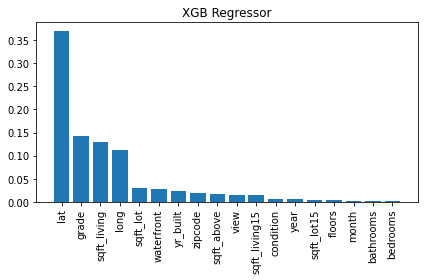

In [8]:
permutation_feature_importance(xgb_reg, 'XGB Regressor', 'xgb')

lat     0.366 +/- 0.011
sqft_living0.284 +/- 0.011
grade   0.216 +/- 0.011
long    0.164 +/- 0.011
waterfront0.031 +/- 0.003
sqft_living150.023 +/- 0.001
yr_built0.019 +/- 0.002
zipcode 0.008 +/- 0.001
view    0.008 +/- 0.000
sqft_lot0.006 +/- 0.001
sqft_lot150.004 +/- 0.001
sqft_above0.004 +/- 0.001
condition0.001 +/- 0.000
year    0.001 +/- 0.000
bedrooms0.001 +/- 0.000


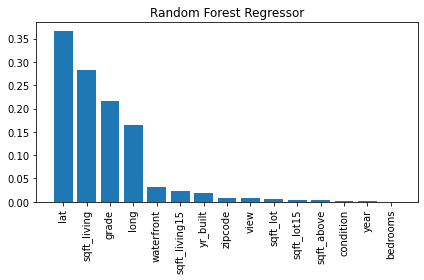

In [9]:
rf = RandomForestRegressor()
rf.fit(train_X, train_Y)
permutation_feature_importance(rf, 'Random Forest Regressor', 'rf')

lat     0.417 +/- 0.014
sqft_living0.216 +/- 0.010
grade   0.177 +/- 0.009
long    0.147 +/- 0.011
sqft_lot0.047 +/- 0.002
waterfront0.030 +/- 0.003
yr_built0.024 +/- 0.002
view    0.016 +/- 0.001
sqft_living150.015 +/- 0.001
zipcode 0.014 +/- 0.001
sqft_above0.012 +/- 0.002
sqft_lot150.010 +/- 0.001
year    0.007 +/- 0.001
floors  0.006 +/- 0.001
condition0.004 +/- 0.001
bathrooms0.002 +/- 0.001
month   0.001 +/- 0.000
bedrooms0.001 +/- 0.000
yr_renovated0.001 +/- 0.000


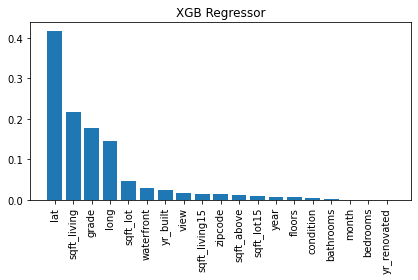

In [10]:
xgb_reg2 = XGBRegressor()
xgb_reg2.fit(train_X, train_Y)
permutation_feature_importance(xgb_reg2, 'XGB Regressor', 'xgb2')

grade   0.208 +/- 0.005
sqft_living0.148 +/- 0.004
lat     0.104 +/- 0.003
yr_built0.085 +/- 0.003
sqft_above0.051 +/- 0.002
waterfront0.042 +/- 0.002
view    0.021 +/- 0.001
bathrooms0.015 +/- 0.001
bedrooms0.015 +/- 0.001
zipcode 0.015 +/- 0.001
long    0.011 +/- 0.001
condition0.004 +/- 0.001
sqft_basement0.004 +/- 0.001
year    0.004 +/- 0.001
sqft_living150.003 +/- 0.000
sqft_lot150.002 +/- 0.001
yr_renovated0.001 +/- 0.000
floors  0.000 +/- 0.000


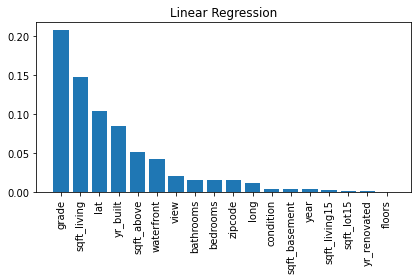

In [11]:
linreg = LinearRegression()
linreg.fit(train_X, train_Y)
permutation_feature_importance(linreg, 'Linear Regression', 'lr')